<a href="https://colab.research.google.com/github/RyazMax/ML-in-IndustryLabs/blob/main/LW2/Lab2_EDA%2Bbaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers

In [ ]:
import os
import re
from functools import partial
from operator import itemgetter
from sortedcontainers import SortedList

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from xgboost import XGBClassifier

import torch

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import PIL
from PIL import Image

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
RS = 65536

def movie_img(id):
  return os.path.join('/content/drive/MyDrive/ITMO/3SEM/IndML/Lab2/imdb_proj/img', f'{id}.png')

### Load the data

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/ITMO/3SEM/IndML/Lab2/imdb_proj/movies.csv')

In [ ]:
movies.head(15)

,id,title,short,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,Romance,Sci-Fi,Short,Sport,Superhero,Talk-Show,Thriller,War,Western,\N
0,10,Leaving the Factory,Workers leaving the Lumière factory for lunch ...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,12,The Arrival of a Train,A train arrives at La Ciotat station.,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,70,Demolition of a Wall,Auguste Lumière directs four workers in the de...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,91,The House of the Devil,"With the help of a magic cauldron, Mephistophe...",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,211,"The Astronomer's Dream; or, the Man in the Moon",An astronomer falls asleep and has a strange d...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,228,La bonne absinthe,A customer places an order at a cafe. While re...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,359,L'homme à la tête en caoutchouc,A chemist carries out a bizarre experiment wit...,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
7,417,A Trip to the Moon,A group of astronomers go on an expedition to ...,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,439,The Great Train Robbery,A group of bandits stage a brazen train hold-u...,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,447,Life of an American Fireman,A fireman rushes into a carriage to rescue a w...,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Info

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22240 entries, 0 to 22239
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           22240 non-null  int64 
 1   title        22240 non-null  object
 2   short        22005 non-null  object
 3   Action       22240 non-null  int64 
 4   Adult        22240 non-null  int64 
 5   Adventure    22240 non-null  int64 
 6   Animation    22240 non-null  int64 
 7   Biography    22240 non-null  int64 
 8   Comedy       22240 non-null  int64 
 9   Crime        22240 non-null  int64 
 10  Documentary  22240 non-null  int64 
 11  Drama        22240 non-null  int64 
 12  Family       22240 non-null  int64 
 13  Fantasy      22240 non-null  int64 
 14  Film-Noir    22240 non-null  int64 
 15  Game-Show    22240 non-null  int64 
 16  History      22240 non-null  int64 
 17  Horror       22240 non-null  int64 
 18  Music        22240 non-null  int64 
 19  Musical      22240 non-nu

dropna

In [ ]:
movies = movies.dropna(axis=0)

### Pre-process data

Genre info

In [ ]:
META = ['id',	'title', 'short']
init_genres = [c for c in movies.columns if c not in META]
print(f'Total genres: {len(init_genres)}'
      '\nGenres:\n\t' 
      + '\n\t'.join([', '.join(init_genres[i*5:(i+1)*5]) for i in range(len(init_genres) // 5 + 1)]))

Total genres: 29
Genres:
	Action, Adult, Adventure, Animation, Biography
	Comedy, Crime, Documentary, Drama, Family
	Fantasy, Film-Noir, Game-Show, History, Horror
	Music, Musical, Mystery, News, Romance
	Sci-Fi, Short, Sport, Superhero, Talk-Show
	Thriller, War, Western, \N


In [ ]:
real_genres = ['Action',
               'Adventure',
               'Animation',
               'Biography',
               'Comedy',
               'Crime',
               'Documentary',
               'Drama',
               'Family',
               'Fantasy',
               'Film Noir',
               'History',
               'Horror',
               'Music',
               'Musical',
               'Mystery',
               'Romance',
               'Sci-Fi',
               'Short Film',
               'Sport',
               'Superhero',
               'Thriller',
               'War',
               'Western']

igs = set(init_genres)
rgs = set(real_genres)
diff_genres = igs.union(rgs).difference(igs.intersection(rgs))
print(f'Inirial remaining: {list(igs.intersection(diff_genres))}'
      f'\nReal remaining: {list(rgs.intersection(diff_genres))}')

Inirial remaining: ['Talk-Show', 'Short', 'Film-Noir', 'Adult', '\\N', 'News', 'Game-Show']
Real remaining: ['Short Film', 'Film Noir']


In [ ]:
init_real_genre_map = {'Film-Noir': 'Film Noir', 'Short': 'Short Film'}
movies = movies.rename(columns=init_real_genre_map)
movies = movies.drop(list(igs.intersection(diff_genres).difference(init_real_genre_map.keys())), axis=1)
assert set(movies.columns).difference(META) == rgs

Prepare textual data

In [ ]:
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
swds_eng = stopwords.words('english')

def clear_text(t):
  t = t.lower()
  return ' '.join([w 
                for w in map(lemmatizer.lemmatize, nltk.word_tokenize(t)) 
                if w.replace('-', '').isalpha() 
                  and w not in swds_eng])
  # return ' '.join([stemmer.stem(w) for w in t.split(' ') if w not in stopwords.words('english')])

movies['short_clear'] = movies['short'].apply(clear_text)

Bag Of Words

In [ ]:
vectorizer = CountVectorizer(max_features=252)
short_bows = vectorizer.fit_transform(movies['short_clear']).toarray()
short_bows = pd.DataFrame(short_bows, columns=vectorizer.get_feature_names_out())
short_bows.sum(axis=1).describe()

Term Frequency - Inverse Document Frequency

In [ ]:
tfidf = TfidfVectorizer(max_features=175)
short_tfidf = tfidf.fit_transform(movies['short_clear']).toarray()
short_tfidf = pd.DataFrame(short_tfidf, columns=tfidf.get_feature_names_out())
short_tfidf.max(axis=0)

agent       1.000000
american    1.000000
another     1.000000
around      1.000000
attempt     1.000000
              ...   
work        1.000000
world       1.000000
year        1.000000
york        0.808141
young       1.000000
Length: 175, dtype: float64

# EDA

### Explore target

### Charts

Since we have multilabel classification, let's investigate rows' label counts

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


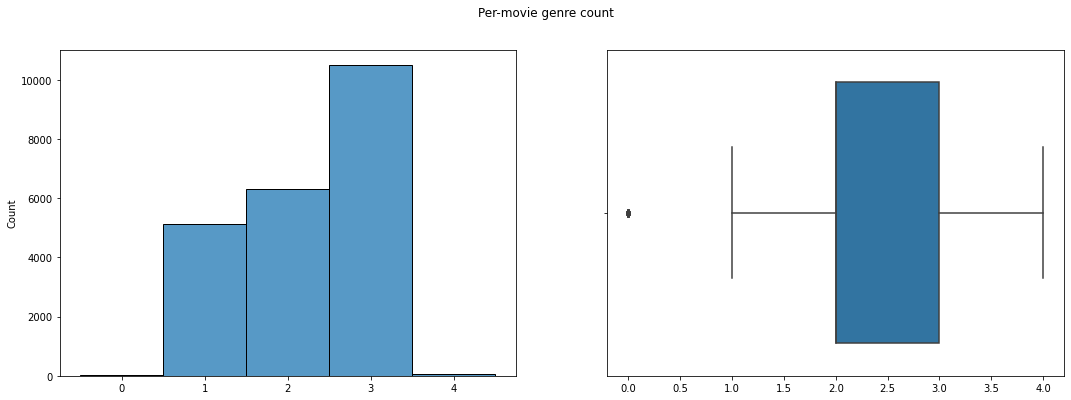

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.suptitle('Per-movie genre count')
sns.histplot(movies[real_genres].sum(axis=1), discrete=True, ax=ax[0])
sns.boxplot(movies[real_genres].sum(axis=1), ax=ax[1])

Count outliers

In [ ]:
movies[real_genres].sum(axis=1).value_counts()

3    10493
2     6310
1     5120
4       56
0       26
dtype: int64

Insights:


*   Approx. a half of movies have three genres. The rest is divided between 1 and 2 genres almost equally.
*   We should clear outlies with 0 genres before training.
*   Probably, we can speed-up training by punishing model more for more than (or or equals to) 4 genres.


Let's check genre occurence distribution

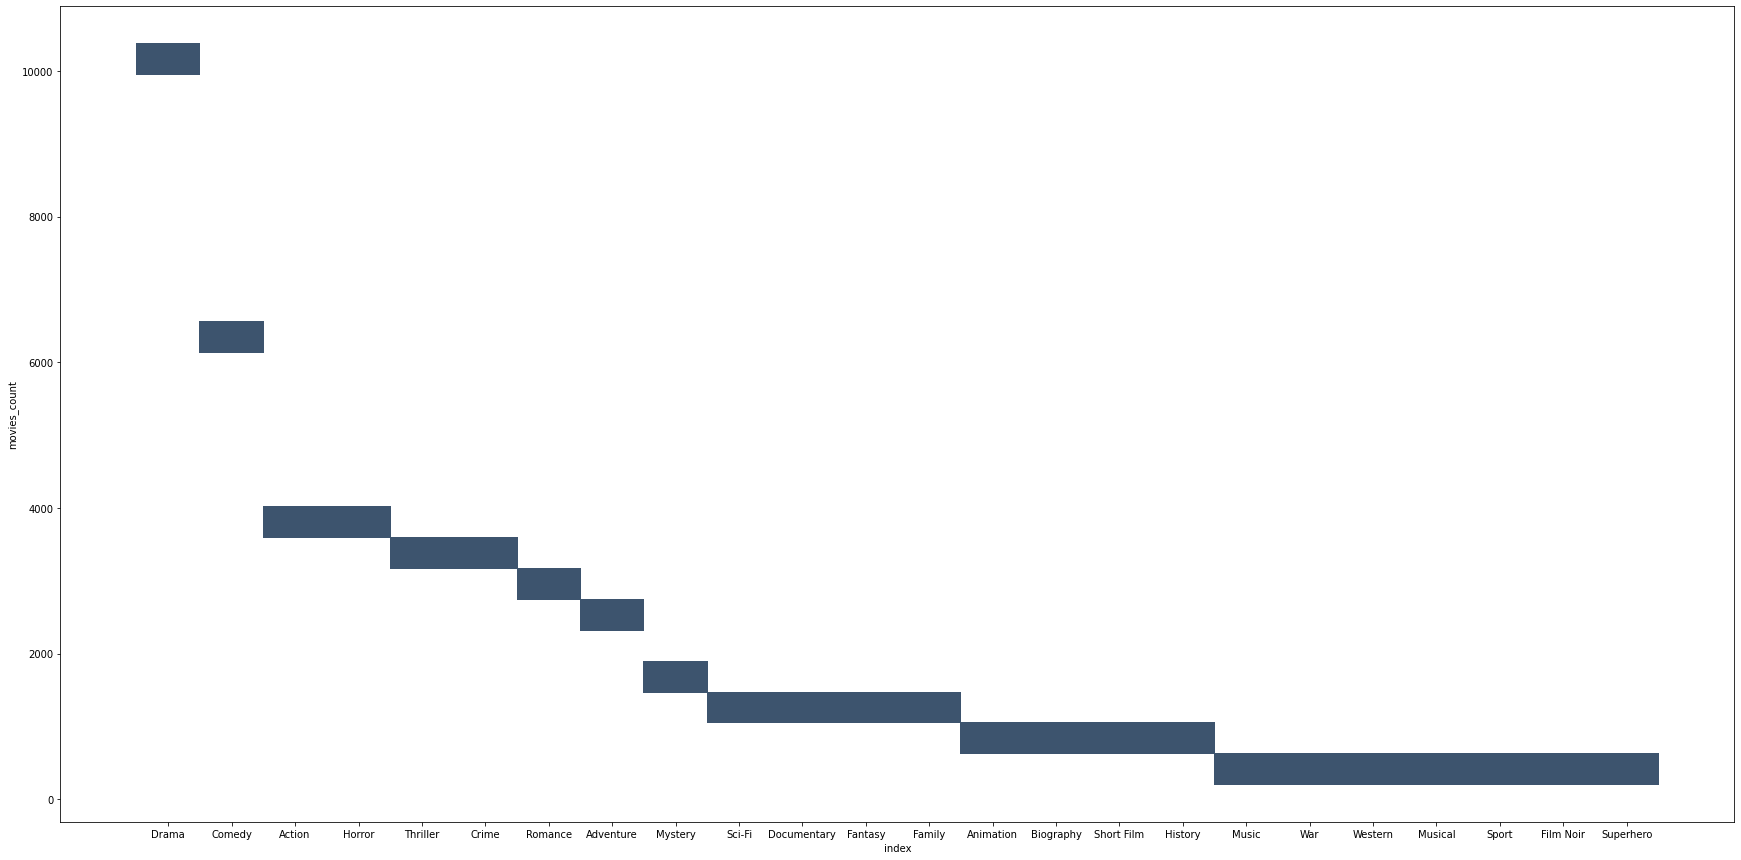

In [ ]:
plt.figure(figsize=(30,15))
genre_counts = pd.DataFrame(movies[real_genres].sum(axis=0), columns=['movies_count']).reset_index()
genre_counts = genre_counts.rename({'index': 'genre'}).sort_values('movies_count', ascending=False).reset_index(drop=True)
sns.histplot(genre_counts, x='index', y='movies_count', bins=len(real_genres))
# sns.histplot(movies[real_genres])

In [ ]:
genre_counts.head()

,index,movies_count
0,Drama,10375
1,Comedy,6241
2,Action,3940
3,Horror,3606
4,Thriller,3495


Cross correlation can help capture most relative genres

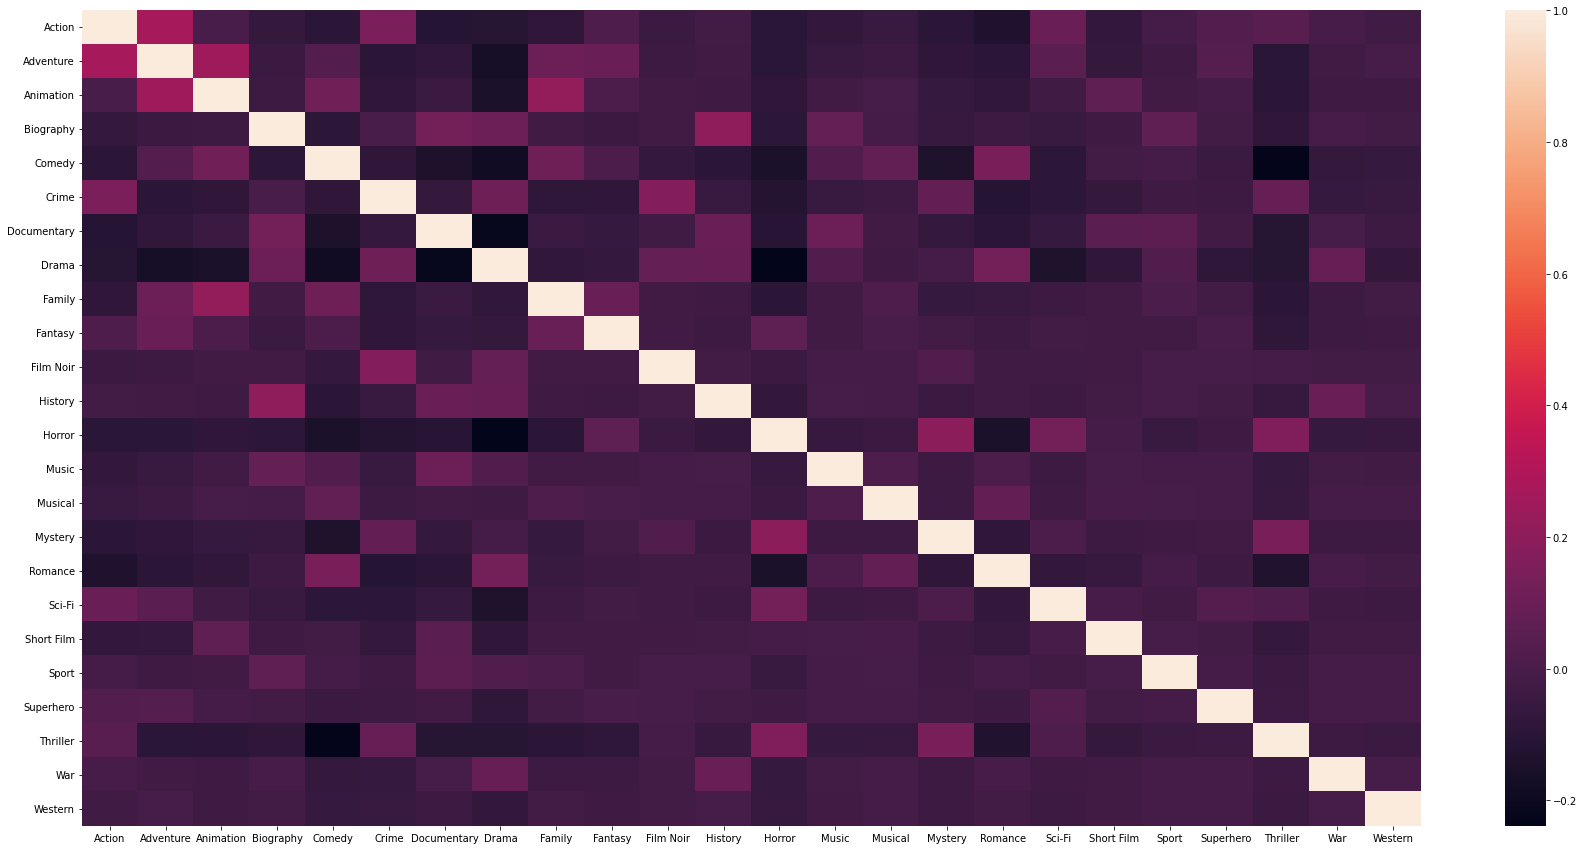

In [ ]:
plt.figure(figsize=(30, 15))
movie_genres_corr_df = movies[real_genres].corr()
sns.heatmap(movie_genres_corr_df)

We can see that Adventure correlates with Action and Animation. Also, some other co-occurences can be told to occur more frequently then the majority. 

Insights:
* Probably, we can create more pseudo classes by including the most frequent combinations into genre list. This can help balance distribution of number of genres per movie.

## Text data

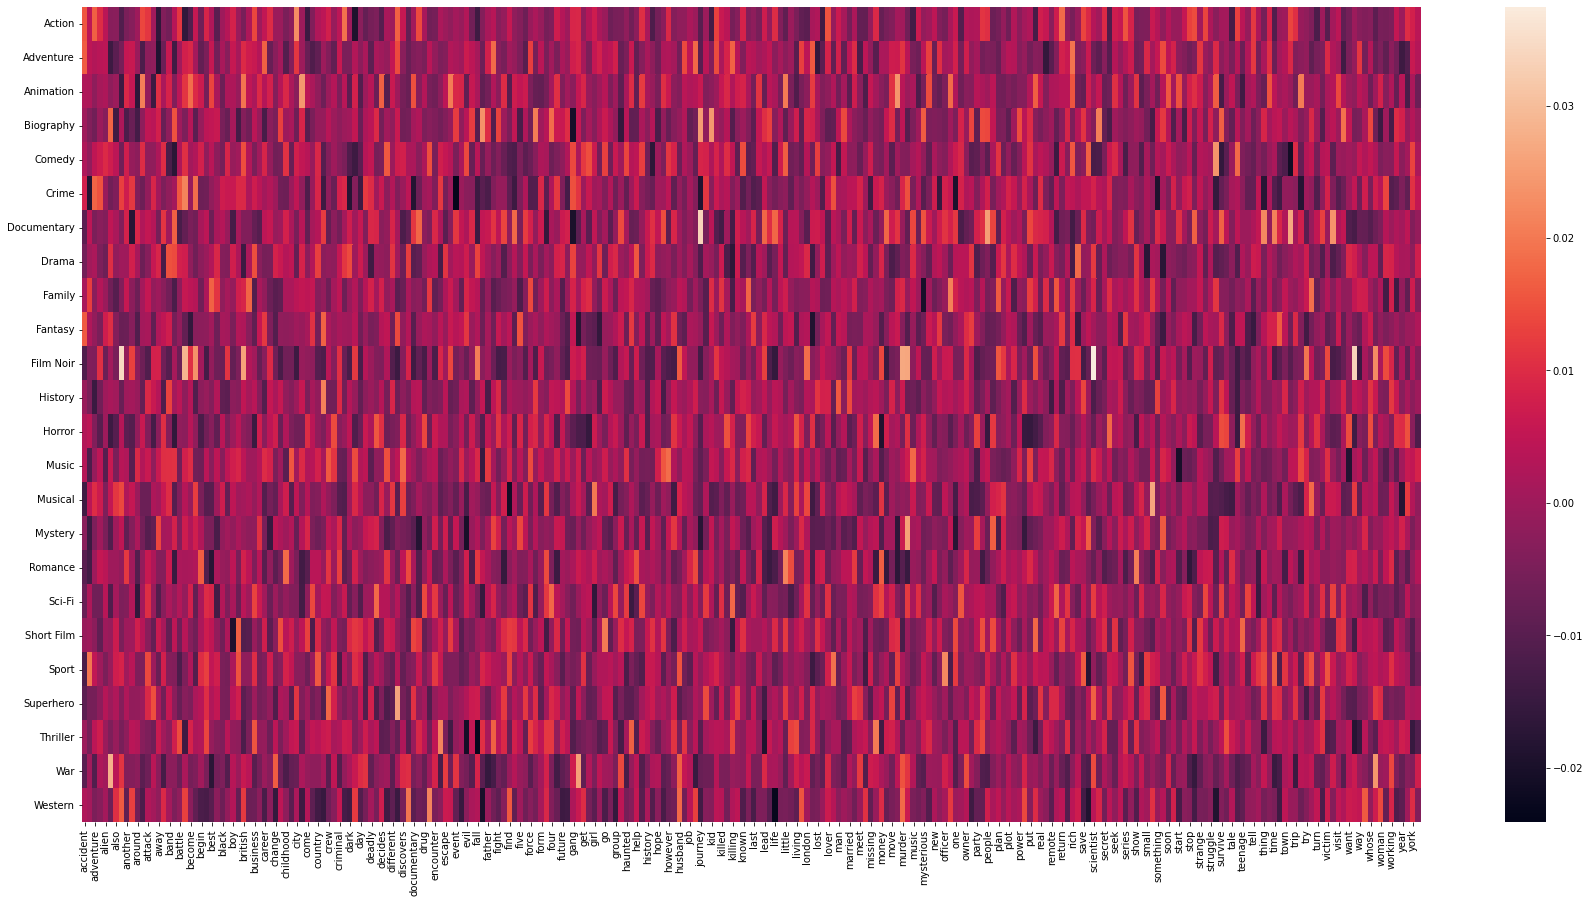

In [ ]:
plt.figure(figsize=(30, 15))
movie_genre_word = pd.DataFrame({f: movies[real_genres].corrwith(short_bows[f], axis=0) for f in short_bows.columns})
sns.heatmap(movie_genre_word)

Top-5 words per genre

In [ ]:
wds = movie_genre_word.columns
best = pd.DataFrame.from_records([[wds[i] for i, _ in sorted(enumerate(wd_info), key=itemgetter(1), reverse=True)[:5]]
                                  for _, wd_info in movie_genre_word.iterrows()], 
                                 columns=['Best', 'second', 'third', 'fourth', 'fifth'],
                                 index=movie_genre_word.index)
display(best)

,Best,second,third,fourth,fifth
Action,city,dangerous,return,adventure,discover
Adventure,rich,female,join,killing,career
Animation,college,movie,artist,true,even
Biography,journey,kid,family,search,forced
Comedy,student,team,school,little,detective
Crime,beautiful,becomes,adventure,battle,agent
Documentary,journey,travel,people,village,thing
Drama,run,help,band,business,dark
Family,old,trying,land,brother,best
Fantasy,couple,together,accident,five,discover


# Baseline model
* Text: Count Vectorizer + XGB
* Pict: Convolutional network + classifier layer
* Ensemble: mean

## Text

### Attempt 1
Count Vectorizer + XGB

In [ ]:
def xgb_multilabel():
  X_train, X_test, y_train, y_test = train_test_split(short_tfidf, movies[real_genres], test_size=0.2, random_state=RS)

  # create XGBoost instance with default hyper-parameters
  xgb_estimator = XGBClassifier()

  # create MultiOutputClassifier instance with XGBoost model inside
  multilabel_model = MultiOutputClassifier(xgb_estimator)

  # fit the model
  multilabel_model.fit(X_train, y_train)

  # evaluate on test data
  y_pred = multilabel_model.predict(X_test)
  return y_test, y_pred

def describe_attempt(y_true, y_pred):
  print('Prediction on test data: \n' 
        + ('\n'.join([f'{n}: {f(y_true, y_pred):.5f}' for n, f in [('acc', accuracy_score), 
                                                                  ('prec', partial(precision_score, average='macro')), 
                                                                  ('f1',  partial(f1_score, average='macro'))]])))

In [ ]:
describe_attempt(*xgb_multilabel())

Prediction on test data: 
acc: 0.06521
prec: 0.47211
f1: 0.11453


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Attempt 2
OneVsRest

In [ ]:
multilabel_binarizer = MultiLabelBinarizer()

def xgb_binarized():
  # y = multilabel_binarizer.fit_transform(movies[real_genres].itertuples(index=False))
  
  X_train, X_test, y_train, y_test = train_test_split(short_tfidf, movies[real_genres], test_size=0.2, random_state=RS)

  # create XGBoost instance with default hyper-parameters
  xgb_estimator = XGBClassifier()

  # create OneVsRestClassifier
  ovr = OneVsRestClassifier(xgb_estimator)

  # fit the model
  ovr.fit(X_train, y_train)

  # evaluate on test data
  y_pred = ovr.predict(X_test)
  return ovr, (y_test, y_pred)


In [ ]:
xgb_bin_model, xgb_bin_eval = xgb_binarized()
describe_attempt(*xgb_bin_eval)

Prediction on test data: 
acc: 0.06339
prec: 0.46405
f1: 0.08392


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Attempt 3
CNN

In [ ]:
from sklearn.utils import class_weight

from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D, concatenate, Concatenate, BatchNormalization, Dropout
from keras.models import Model, Sequential, model_from_json
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils, pad_sequences

CNN_FEATURES = 150
CNN_SEQ = 20
CNN_EMBED = 75

CNN_BATCH = 64
CNN_EPOCHS = 30

def get_cnn():
  X_train, X_test, y_train, y_test = train_test_split(movies['short_clear'], movies[real_genres], test_size=0.2, random_state=RS)
  tokenizer = Tokenizer(num_words=CNN_FEATURES)
  tokenizer.fit_on_texts(movies['short_clear'])
  sequences_train = tokenizer.texts_to_sequences(X_train)
  sequences_test = tokenizer.texts_to_sequences(X_test)
  X_train = pad_sequences(sequences_train, maxlen=CNN_SEQ, padding='post')
  X_test = pad_sequences(sequences_test, maxlen=CNN_SEQ, padding='post')
  label = pd.DataFrame({'genres': [r[r==1].index for _, r in movies[real_genres].iterrows()]})
  # Balanced class weights
  # class_weights = class_weight.compute_class_weight('balanced',
  #                                                classes=np.array(real_genres),
  #                                                y=label)
  # y_train = np.transpose(y_train)
  # y_test = np.transpose(y_test)
  # y_train = np_utils.to_categorical(y_train)
  # y_test = np_utils.to_categorical(y_test)

  model = get_cnn_model()

  model.fit(
    x=np.array(X_train), y=np.array(y_train),
    batch_size=CNN_BATCH,
    epochs=CNN_EPOCHS,
    validation_data=(np.array(X_test), y_test),)
    # callbacks=[tensorboard, checkpointer],
    # class_weight=class_weights)
  
  print('\n')
  print('====================================')
  print(' Validation report')
  print('====================================')
  print('\n')
  test_predict_1 = model.predict(np.array(X_test[:10]), verbose=1)
  return model, (np.array(X_test[:10]), test_predict_1, y_test)

def get_cnn_model():
  f1_base = Input(shape=(CNN_SEQ, ), dtype='int32')
  text_embedding = Embedding(input_dim=CNN_FEATURES, output_dim=CNN_EMBED,
                           input_length=CNN_SEQ)(f1_base)
  
  filter_sizes = [3, 4, 5]
  convs = []
  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=256, kernel_size=filter_size, padding='same', activation='relu')(text_embedding)
      l_batch = BatchNormalization()(l_conv)
      l_pool = MaxPooling1D(3)(l_conv)

      convs.append(l_pool)
  
  l_merge = Concatenate(axis=1)(convs)
  l_pool1 = MaxPooling1D(3)(l_merge)
  l_flat = Flatten()(l_pool1)
  l_dense = Dense(128, activation='relu')(l_flat)
  x = Dropout(0.5)(l_dense)
  #f1_x = Flatten()(f1_x)
  x = Dense(len(real_genres), activation='softmax')(x)
  model = Model(inputs=f1_base, outputs=x)

  # determine Loss function and Optimizer
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
cnn_model, (cnn_x, cnn_y_pred, cnn_y_true) = get_cnn()

KeyboardInterrupt: ignored

## Image processing

### Attempt 1

add image names to data

In [ ]:
images_ids = {int(id.split('.')[0]): id for id in os.listdir('/content/drive/MyDrive/ITMO/3SEM/IndML/Lab2/imdb_proj/img')}
movies['img_name'] = movies['id'].apply(lambda x: images_ids[x])
movies['img_name'].iloc[:5]

0     10.jpg
1     12.jpg
2     70.jpg
3     91.jpg
4    211.jpg
Name: img_name, dtype: object

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
from transformers import ViTForImageClassification, \
                         Trainer, TrainingArguments, TrainerCallback, TrainerState, TrainerControl
from datasets import Dataset, DatasetDict, load_metric
from time import time

vit_prec = load_metric("precision")
vit_rec = load_metric("recall")
vit_f1 = load_metric("f1")

class ViTCallback(TrainerCallback):
  def on_step_end(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
    if not hasattr(self, '_prev_epoch'):
      setattr(self, '_prev_epoch', 0)
      setattr(self, '_time', time())

    ep = int(state.epoch)
    if ep < self._prev_epoch:
      setattr(self, '_prev_epoch', 0)
      setattr(self, '_time', time())

    if ep > self._prev_epoch:
      print()
    
    t = time() - self._time
    print(f'\rEpoch {ep} {(state.epoch - ep) * 100:.3f}% (total {state.global_step} / {state.max_steps})'
            + f' {t//3600:.0f}h : {t//60:.0f}m : {t:.2f}s'
            + f'\t Best precision: {state.best_metric}')


def compute_metric(p, metric=None):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

def metrics_computation():
  return [partial(compute_metric, metric=vit_prec),
          partial(compute_metric, metric=vit_rec),
          partial(compute_metric, metric=vit_f1)]

def imgf(n):
  return os.path.join('/content/drive/MyDrive/ITMO/3SEM/IndML/Lab2/imdb_proj/img', n)

def transform_Dataset(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

def transform_Dataframe_col(col):
  return feature_extractor([x for x in col], return_tensors='pt').pixel_values

def paths2images(d):
  return [Image.open(imgf(n)) for n in d]

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

def vit():
  if 'Image' not in movies.columns:
    movies['Image'] = paths2images(movies['img_name'])
  labels = movies[real_genres].itertuples(index=False)
  ds = pd.DataFrame({'image_file_path': movies['img_name'].apply(imgf),
                     'image': transform_Dataframe_col(movies['Image']), 
                     'labels:': labels})
  
  ds_train, ds_test = train_test_split(ds, test_size=0.2, random_state=RS)
  ds_train, ds_val = train_test_split(ds_train, test_size=0.2, random_state=RS)

  ds = DatasetDict({
      'train': Dataset.from_pandas(ds_train, split='train'),
      'validation': Dataset.from_pandas(ds_val, split='validation'),
      'test': Dataset.from_pandas(ds_test, split='test')
  })

  # ds = ds.with_transform(transform_Dataset)
  
  model = ViTForImageClassification.from_pretrained(model_name_or_path,
                                                    num_labels=len(real_genres),
                                                    id2label={str(i): c for i, c in enumerate(real_genres)},
                                                    label2id={c: str(i) for i, c in enumerate(real_genres)})
  
  training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/ITMO/3SEM/IndML/Lab2/model_vit",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
  )

  trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=metrics_computation(),
    train_dataset=ds['train'],
    eval_dataset=ds['validation'],
    tokenizer=feature_extractor,
    callbacks=[ViTCallback()]
  )

  train_results = trainer.train()
  trainer.save_model()
  trainer.log_metrics("train", train_results.metrics)
  trainer.save_metrics("train", train_results.metrics)
  trainer.save_state()

  return train_results, trainer
  
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


In [ ]:
vit_result, vit_trainer = vit()

ValueError: ignored